# Report

## Introduction and data

## Motivation

The project idea is based on a CNN news article regarding working hours in South Korea (https://edition.cnn.com/2018/07/02/health/south-korea-work-hours/index.html). It sais that South Korea cutted its work limit from 68 hours a week to 52. A comparison of "Average annual hours actually worked per worker"  by country (https://stats.oecd.org/Index.aspx?DataSetCode=ANHRS#) shows that in 2021 South Korea had the 4th highest amount of hours of 35 countries tracked by OECD. The average was 1.915 hours where Germany worked the least with 1.349 hours.

South Korea and Germany are both known for strong economies but obviously behave different regarding working hours. Due to this fact the project group (herein, "we") decided to investigate the subject of **labor productivity**. **Productivity** is commonly defined as a ratio between the volume of output and the volume of inputs. In other words, it measures how efficiently production inputs, such as **labour**, is used in an economy to produce a given level of output. Hence it is a key source for economic growth and affects our future worklife.

## Research Questions
1) Does the longer average annual working hours increase labor productivity?
2) What is the most related factor in improving labor productivity?
  - Annual working hours per worker
  - GDP of the country
  - Gini coefficient of country
  - Life satisfaction level of worker
  - Amount of health expenditure of worker

Please find the literature, our research question is motivated by, in the sources.


## Hypotheses
1) There is no correlation between working hours and labor productivity. (= Null hypothesis of our first research question)
2) Life satisfaction level of country is the most related factor (regarding factors listed above) in improving labor productivity.

## Data description

The initial data set consinst of 3.471 observations with a time range from 1950 to 2017. Due to fact that time series analysis is not the goal of this project, the data set was flagged on the latest observations of 2017. The adjusted data set consinst of 66 observations, 11 columns.

### Variables description

First four columns include four spatial and temporal dimensions:
- Continent: Continent name
- Country: Country name
- Country Code: Country codes by alpha-3
- Year: Calendar Year - Only 2017 data was considered in this analysis to satisfy the independence condition

At least six columns have useful and unique numeric predictors, and each column contains different numeric informations that could be independent variable. There is one variable that can be defined as a dependent variable to perform an analysis based on the research problem described below.
- Resonable dependent variable:  
  - Productivity: Labour Productivity is measured as gross domestic product (GDP) per hour of work. This data is adjusted for inflation and for differences in the cost of living between countries.
- Independent variable
  - Ø-working hours: Working hours are the annual average per worker
  - GDP: GDP per capita by country
  - Population: Population by country
  - Gini coefficient: Determinates the level of income inequality (0 = perfect equality / 1 = maximal inequality)
  - Life safisfaction: The level of life satisfaction for each country has been measured by survey: “Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”
  - Health expenditure: Healthcare expenditure per capita is measured in current international-$, which adjusts for price differences between countries.

Please find the source description in the Appendix.

### Limitations
- The amount of observations is very small. The sample size could undermine the validity of the model results.
- As Productivity is a figure calculated from Ø-working hours and GDP it could cause multicollinearity.

The following table (Table 1) shows the first 10 observations of the data set consolidated from the exports:

In [268]:

# Setup
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

import seaborn as sns # Python data visualization library based on matplotlib. Used pairplot function in data exploration and heatmap function for visualization of multicollinearity check

# statmodels - supports specifying models using R-style formulas and pandas DataFrames
from statsmodels.stats.outliers_influence import variance_inflation_factor # Measure for the increase of the variance of the parameter estimates if an additional variable, given by the design matrix is added to the linear regression. It is a measure for multicollinearity of the design matrix
from statsmodels.tools.tools import add_constant # Add a column to an array
from statsmodels.formula.api import ols # API that focuses on models and the most frequently used statistical test, and tools for Ordinary Least Squares regression

### Table 1: Overview Dataframe

In [183]:
# import data and first view on dataframe
df = pd.read_csv('https://raw.githubusercontent.com/jh294/project/main/data/raw/Labor_Productivity_Analysis_final.csv',sep=';',decimal=',')
df = df.rename(columns = {'gini_coefficient':'Gini coefficient'})
df.head(5)

,Continent,Country,Code,Year,Average annual working hours per worker,GDP per capita,Population,Gini coefficient,Life satisfaction,Productivity,Current health expenditure per capita
0,Americas,Argentina,ARG,2017,1691.5363,23272.18,44054616,NaN,6.085561,30.955460,2470.11
1,Oceania,Australia,AUS,2017,1731.4943,52536.19,24590336,NaN,7.233995,60.341679,4715.83
2,Europe,Austria,AUT,2017,1613.0519,51954.28,8797497,0.297376,7.195361,64.780170,5641.18
3,Asia,Bangladesh,BGD,2017,2232.3542,4112.70,161793968,NaN,5.114217,4.307637,101.18
4,Europe,Belgium,BEL,2017,1544.2690,45150.20,11384491,0.273880,6.772138,68.516521,5450.48


As explained in the variables description above, we set different variables as independent variables. In setting variables, we collected and selected factors that might be related to Productivity, and by doing so we attempted to identify which independent variables were most closely related to Productivity, our response variable.
For example, Life satisfaction is believed to be closely related to Productivity, but it is difficult to answer the question of whether this factor has the greatest influence among the Productivity-related variables. Therefore, further analysis can identify the relationship between this variable and the response variable.

### Table 2: Data information

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Continent                                66 non-null     object 
 1   Country                                  66 non-null     object 
 2   Code                                     66 non-null     object 
 3   Year                                     66 non-null     int64  
 4   Average annual working hours per worker  66 non-null     float64
 5   GDP per capita                           66 non-null     float64
 6   Population                               66 non-null     int64  
 7   Gini coefficient                         48 non-null     float64
 8   Life satisfaction                        65 non-null     float64
 9   Productivity                             65 non-null     float64
 10  Current health expenditure per capita    64 non-null

## Data corrections

As we can already investigate null values in table 1 and table 2, first of all we check the dataframe for these cases.

### Table 3: Shortening of variable names
- We shortened some variable names to make the graphics easier to understand.

In [185]:
df = df.rename(columns={'Average annual working hours per worker': 'Ø working hours', 
                        'GDP per capita': 'GDP',
                        'Population': 'Population',
                        'Gini coefficient': 'Gini coefficient',
                        'Life satisfaction': 'Life satisfaction',
                        'Productivity': 'Productivity',
                        'Current health expenditure per capita': 'Health expenditure'})

- Average annual working hours per worker -> Ø working hours
- GDP per capita -> GDP
- Current health expenditure per capita -> Health expenditure


### Table 3: Null values

In [186]:
# Check for missing values for each variable.
print(df.isnull().sum())

Continent              0
Country                0
Code                   0
Year                   0
Ø working hours        0
GDP                    0
Population             0
Gini coefficient      18
Life satisfaction      1
Productivity           1
Health expenditure     2
dtype: int64


This information reflects that our data set contains some null values we need to handle with. As a rule of thumb a linear regression with one dependent and one independent variable requires at least 30 observations. Hence it can be assumed that the number of observations is sufficient for a simple linear regression model. Regarding a multiple linear regression model for each additional indipendent variable added to the equation an additional 10 observations are required (https://home.csulb.edu/~msaintg/ppa696/696regmx.htm#:~:text=Regression%20with%20only%20one%20dependent,variable%20added%20to%20the%20equation). 
In our case, a dataset of at least 80 observations would be required to take every independent variable into account. For this reason we cannot afford to eliminate the observations with missing values. Alternativley we will appropriately replace the missing values with mean or median. Despite the data correction we furthermore need to think about eleminating isolated variables of our multiple linear regression model. 

Additionally we were thinking about a method called oversampling to add artificial samples. However, research on this subject revealed, that this method only works for categorical variables to adjust the class distribution of a data set. Hence it is not practicable for this project.

To deal with existing missing values we had to figure out what is a better measure of the central tendency of data and use that value to appropriately replace missing values.
We generated distribution plots to decide which techniques to use.
    - Outliers data points will have a significant impact on the mean and hence, in such cases, it is not recommended to use the mean for replacing the missing values. 
    - For symmetric data distribution, one can use the mean value for imputing missing values.

Please find the additional boxplot visualization in the Appendix.

### Chart 1: Distribution Splot

In [187]:
alt.Chart(df).mark_bar().encode(
    alt.X(alt.repeat("column"), type="quantitative", bin=True),
    y='count()',
).properties(
    width=100,
    height=100
).repeat(
    column=['Productivity', 'Ø working hours', 'GDP', 'Population','Gini coefficient','Life satisfaction','Health expenditure']
)

c:\Users\ji_so\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

Exploration of data distribution with histograms shows that all variables are unimodel. Productivity, GDP and Health expenditure are right skrewed variables whereas the other variables ara symmetry. 

Gini coefficient, Life satisfaction, Productivity and Health expenditure have no symmetric data distribution. Hence we replace the missing values with median.

In [188]:
df['Gini coefficient'] = df['Gini coefficient'].fillna(df['Gini coefficient'].median())
df['Life satisfaction'] = df['Life satisfaction'].fillna(df['Life satisfaction'].median())
df['Productivity'] = df['Productivity'].fillna(df['Productivity'].median())
df['Health expenditure'] = df['Health expenditure'].fillna(df['Health expenditure'].median())

As we adjusted all variables with null values, we make a final check.

### Table 4: Check adjusted null values

In [189]:
#check
print(df.isnull().sum())

Continent             0
Country               0
Code                  0
Year                  0
Ø working hours       0
GDP                   0
Population            0
Gini coefficient      0
Life satisfaction     0
Productivity          0
Health expenditure    0
dtype: int64


There is no missing value anymore in our data, but we need an additional final step in our data correction. As we want to undergo a lasso regression model we need at least one categorical variable. Hence we change the type of continent from object to category. Table 5 gives information of the adjusted dataset after data corrections.

In [190]:
# variable Continent is categorical
df['Continent'] = df['Continent'].astype('category')

### Exploratory data analysis

In [191]:
summary_statistics = pd.DataFrame(df['Productivity'].describe()).T
summary_statistics

,count,mean,std,min,25%,50%,75%,max
Productivity,66.0,39.129739,23.782922,3.02265,19.646299,34.622095,56.207542,109.488306


In [192]:
alt.Chart(df).mark_bar().encode(
    y=alt.X('Country',
            sort='-x',
            axis=alt.Axis(title="Country", 
                          labelAngle=0,
                          titleAnchor="start")),
    x=alt.Y('Productivity', 
            axis=alt.Axis(title = "Productivity",
                          titleAnchor="end")),
                          color=alt.Color('Continent', legend=alt.Legend(title="Continent by color"))
).properties(
    title='Productivity per Country',
    width=300,
    height=650
)

c:\Users\ji_so\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [193]:
#case by case view
alt.Chart(df).mark_circle(size=100).encode(
    x='Ø working hours:Q',
    y='Productivity:Q',
    color=alt.Color('Continent', legend=alt.Legend(title="Continent by color"))
).interactive(
).properties(
    title='Productivity vs. Ø-working hours',
    width=200,
    height=250
)

alt.Chart(...)

As we can see in our scatterplot, we can assume that there is a negative, linear association between these two variables.

## Methodology

As we work with observational data, we expected a correlation among the predictor variables. The matrix shows numerous high values, especially for productivity and GDP or Productivity and Health expenditure. Hence we have a collinearity problem which could cause a reduction on the precision of our estimated coefficients. It is questionable if we can identify independent variables that are significant as we cannot trust the p-value of our regression model.

## Evaluation of our first hypothesis

**Null hypothesis**: There is no correlation between Ø-working hours and Productivity.

**Alternative hypothesis**: There is a correlation between Ø-working hours and Productivity.

For our first hypothesis we only have to take the variables Productivity and Ø-working hours into account. Form the EDA we assumed a linear relationship of these two variables. Hence we use a single linear regression model for evaluation. With this simple method, we can first exclude all unnecessary variables so that we can look at how our independent variable (Ø-working hours) affects the dependent variable (Productivity).

### **Single linear regression model**

Define X and y variable for later use

In [194]:
# define outcome variable as y_label
y_label_H1 = 'Productivity'

# select features
X_H1 = df[["Ø working hours"]]

# create response
y_H1 = df[y_label_H1]

### Data Splitting

Splitting into train and test data and investigating

In [195]:
X_train_H1, X_test_H1, y_train_H1, y_test_H1 = train_test_split(X_H1, y_H1, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)

X_train_H1.shape, y_train_H1.shape

((52, 1), (52,))

In [196]:
X_train_H1.head(2)

,Ø working hours
34,1518.8575
25,1493.3651


In [197]:
X_test_H1.shape, y_test_H1.shape

((14, 1), (14,))

We make a copy of the training data since we don’t want to alter our data during data exploration. We will use this data for our exploratory data analysis.

In [198]:
df_train_H1 = pd.DataFrame(X_train_H1.copy())
df_train_H1 = df_train_H1.join(pd.DataFrame(y_train_H1))

In [199]:
df_train_H1.head(2)

,Ø working hours,Productivity
34,1518.8575,83.165361
25,1493.3651,59.125016


### Analysis

### Descriptive statistics

In [200]:
df_train_H1.describe().T

,count,mean,std,min,25%,50%,75%,max
Ø working hours,52.0,1861.423508,269.327956,1353.88680,1658.232700,1844.34135,2031.379325,2455.550800
Productivity,52.0,39.929674,24.617458,3.02265,20.278949,37.19092,56.912948,109.488306


### Simple regression model

Introduction simple linear regression

In [201]:
reg_H1 = LinearRegression()
reg2_H1 = KNeighborsRegressor(n_neighbors=3)

### Training & Validation

We cannot ensure how well our model will perform. Therefore, as a better option, we will split our data into two sets: the training set and the test set, and then perform k-fold cross-validation. In k-fold cross-validation, the data set is split into k (here k = 5) iterations into training and test data sets. From each training and testing set we can get the error rate, so with this value we can observe how well our model performs on instances it has never seen before.
If the training error is small (i.e. our model makes few errors in the training set) but the generalization error is high, this means that our model is overfitting the training data.

In [202]:
# cross-validation with 5 folds
scores_H1 = cross_val_score(reg_H1, X_train_H1, y_train_H1, cv=5, scoring='neg_mean_squared_error') *-1
scores2_H1 = cross_val_score(reg2_H1, X_train_H1, y_train_H1, cv=5, scoring='neg_mean_squared_error') *-1

In [203]:
# store cross-validation scores
df_scores_H1 = pd.DataFrame({"lr": scores_H1, 
                          "knn": scores2_H1})

# reset index to match the number of folds
df_scores_H1.index += 1

# print dataframe
df_scores_H1.style.background_gradient(cmap='Blues')

,lr,knn
1,624.227040,734.592660
2,456.552360,593.315306
3,77.597734,111.456937
4,136.651296,75.916928
5,126.544454,385.322855


In [204]:
alt.Chart(df_scores_H1.reset_index()).mark_line(
     point=alt.OverlayMarkDef()
).encode(
    x=alt.X("index", bin=False, title="Fold", axis=alt.Axis(tickCount=5)),
    y=alt.Y(
        alt.repeat("layer"), aggregate="mean", title="Mean squared error (MSE)"
    ),
    color=alt.datum(alt.repeat("layer")),
).repeat(layer=["lr", "knn"])

c:\Users\ji_so\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

In [205]:
df_scores_H1.describe().T

,count,mean,std,min,25%,50%,75%,max
lr,5.0,284.314577,242.195193,77.597734,126.544454,136.651296,456.552360,624.22704
knn,5.0,380.120937,289.762629,75.916928,111.456937,385.322855,593.315306,734.59266


The difference in performance between the two models is relatively small. -> Choose linear regression

### Final Training

In [206]:
# Fit the model
reg_H1.fit(X_train_H1, y_train_H1)

LinearRegression()

Intercept and coefficient:

In [207]:
results_RQ1 = pd.DataFrame({'': ['Intercept','Coefficient'],
                        'Simple Linear Regression': [reg_H1.intercept_, reg_H1.coef_.round(5)]})

results_RQ1

,,Simple Linear Regression
0,Intercept,163.016654
1,Coefficient,[-0.06613]


*Regression equation*
- The intercept, 163,02, is the average predicted Productivity that we assume if the Ø-working hours is 0. To find the average Productivity with Ø-working hours, we simply plug in Ø-working hours=1 to obtain 163,02 - 0,06613 * 1 = 162,95.



Prediction for our test data

In [208]:
y_pred_H1 = reg_H1.predict(X_test_H1)

Result table of single linear regression:

In [209]:
results_SLR = pd.DataFrame({'': ['R²','Adjusted R²','MSE','RMSE','MAE'],
                        'Simple Linear Regression': [(r2_score(y_test_H1, y_pred_H1).round(5)),
                        ((1-(1-r2_score(y_test_H1, y_pred_H1))*((len(X_test_H1)-1)/(len(X_test_H1)-len(X_test_H1.columns)-1))).round(5)),
                        (mean_squared_error(y_test_H1, y_pred_H1).round(5)),
                        (mean_squared_error(y_test_H1, y_pred_H1, squared=False).round(5)),
                        (mean_absolute_error(y_test_H1, y_pred_H1).round(5))]})

results_SLR

,,Simple Linear Regression
0,R²,0.51931
1,Adjusted R²,0.47926
2,MSE,195.77492
3,RMSE,13.99196
4,MAE,11.17991


Model diagnostics:

In [210]:
# Additional function for OLS <- this function will be rolled back after using the OLS function
df.columns = [c.replace(' ','_') for c in df.columns]

In [211]:
Singlie_RM = ols("Productivity ~ Ø_working_hours", data=df).fit()

In [212]:
# print regression results
print(Singlie_RM.summary())

                            OLS Regression Results                            
Dep. Variable:           Productivity   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     71.03
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           5.69e-12
Time:                        17:17:52   Log-Likelihood:                -277.66
No. Observations:                  66   AIC:                             559.3
Df Residuals:                      64   BIC:                             563.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         162.6904     14.801     

Here, the p-value is statistically significant. It shows strong proof against the null hypothesis because since the probability is less than 5%. Based on this, we accept the alternative hypothesis and dismiss the null hypothesis.
- Accepted hypothsis: There is a correlation between Ø-working hours and Productivity.

- However, from this result we can also see that there is strong multicollinearity or other numerical problems in this model. In the case of multicollinearity, this reduces the accuracy of the estimated coefficients, which weakens the statistical power of your regression model. Therefore we might not be able to trust the p-values to identify independent variables that are statistically significant.

In [213]:
df.columns = [c.replace('_',' ') for c in df.columns]

## Evaluation of our second hypothese with using various models

Our second hypothesis relates to more than one independent variable. Therefore, we will use two different models to evaluate this hypothesis: **Multiple linear regression & Lasso regression**

- Life satisfaction level of country is the most related factor (regarding all existing factors) in improving Productivity.



### **Multiple linear regression**

We extend the simple linear regression with additional predictor variables and stick to one response variable. We want to investigate the relationship between those predictor variables and the response variable. The selection of the variables for the model will be done by evaluating the adjusted R², as it describes the variation of outcome explained by a predictor.

### Variable lists

We define X and y variables:
- X = "Ø-working hours", "GDP", "Population", "Gini coefficient", "Life satisfaction", "Health expenditure"
- y = "Productivity"

In [214]:
# define outcome variable as y_label
y_label = 'Productivity'

# select features
features = ["Ø working hours", 
            "GDP",
            "Population",
            "Gini coefficient",
            "Life satisfaction",
            "Health expenditure"
            ]


# create feature data
X = df[features]

# create response
y = df[y_label]

### Data splitting

We split our data into train and test data:

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [216]:
# data exploration set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

## Analysis

### Descriptive statistics

Descriptive statistics of our training data:

In [217]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Ø working hours,52.0,1.861424e+03,2.693280e+02,1353.886800,1.658233e+03,1.844341e+03,2.031379e+03,2.455551e+03
GDP,52.0,3.399115e+04,2.126770e+04,3950.930000,1.837127e+04,3.070581e+04,4.625722e+04,9.059755e+04
Population,52.0,9.095150e+07,2.667830e+08,343641.000000,5.700403e+06,1.626382e+07,5.337656e+07,1.410276e+09
Gini coefficient,52.0,3.358921e-01,5.104864e-02,0.232378,3.052685e-01,3.407793e-01,3.566471e-01,4.971548e-01
Life satisfaction,52.0,6.190933e+00,9.956634e-01,3.248770,5.604619e+00,6.242094e+00,7.053873e+00,7.780348e+00
Health expenditure,52.0,2.806152e+03,2.066024e+03,101.180000,1.085205e+03,2.236172e+03,4.477472e+03,7.989640e+03
Productivity,52.0,3.992967e+01,2.461746e+01,3.022650,2.027895e+01,3.719092e+01,5.691295e+01,1.094883e+02


### Exploratory data analysis

We can see the relationship between variables by using pairplot and correlation table.

c:\Users\ji_so\anaconda3\envs\stats\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


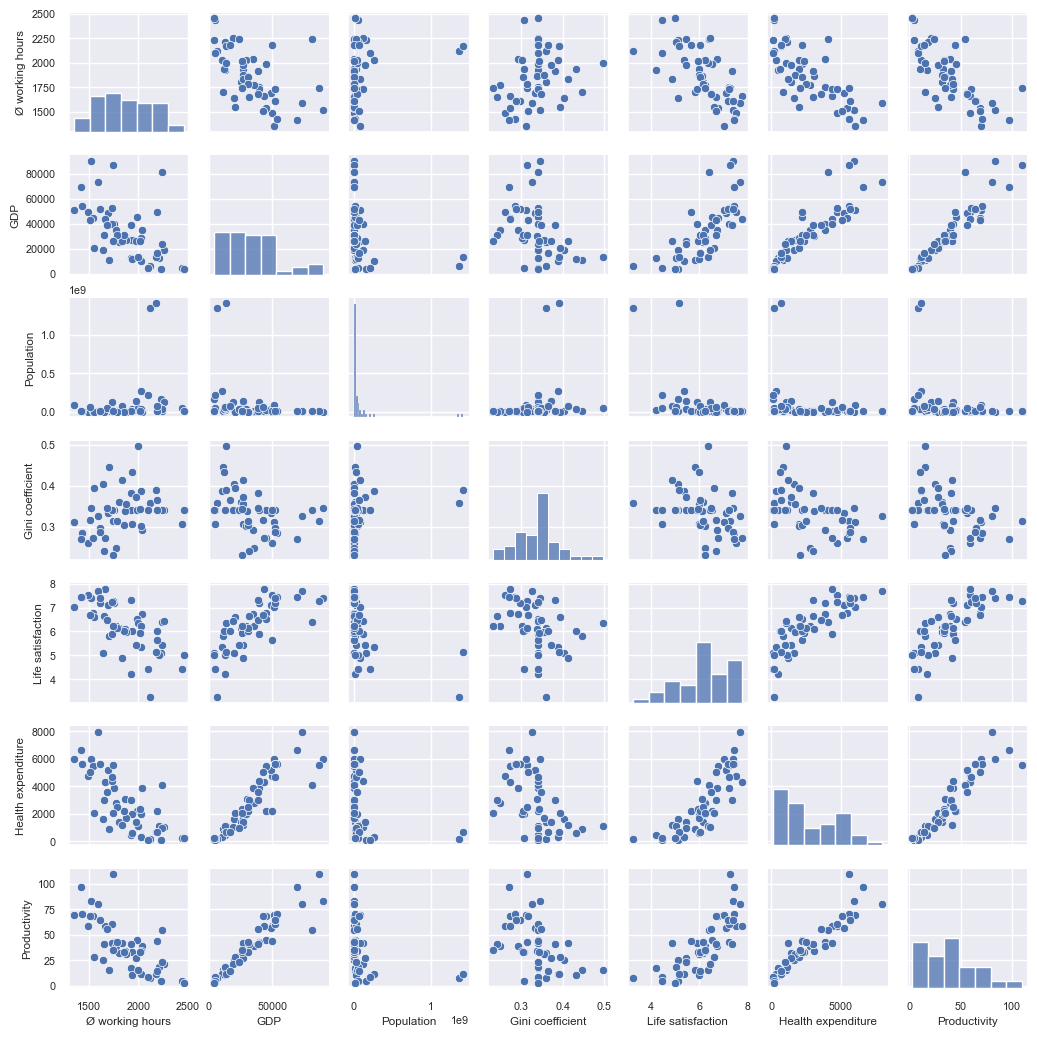

In [287]:
sns.pairplot(df_train, size=1.5)

Findings:

- Positive association between GDP and Productivity, between Life satisfaction and Productivity as well as between Health expenditure and Productivity.
- Negative association between Ø-working hours and Productivity as well as between Gini coefficient and Productivity.
- Relationships seem to be linear in all cases.

### Relationships

We can inspect correlation between outcome and possible predictors:

In [220]:
corr = df_train.corr()
corr[y_label].sort_values(ascending=False)

Productivity          1.000000
GDP                   0.933883
Health expenditure    0.932841
Life satisfaction     0.779188
Population           -0.323232
Gini coefficient     -0.459000
Ø working hours      -0.723444
Name: Productivity, dtype: float64

We can take a look at all correlations:

In [221]:
corr.style.background_gradient(cmap='Blues')

,Ø working hours,GDP,Population,Gini coefficient,Life satisfaction,Health expenditure,Productivity
Ø working hours,1.000000,-0.560226,0.271971,0.282679,-0.660058,-0.743732,-0.723444
GDP,-0.560226,1.000000,-0.306050,-0.384522,0.751129,0.885845,0.933883
Population,0.271971,-0.306050,1.000000,0.207679,-0.476370,-0.304074,-0.323232
Gini coefficient,0.282679,-0.384522,0.207679,1.000000,-0.356457,-0.475925,-0.459000
Life satisfaction,-0.660058,0.751129,-0.476370,-0.356457,1.000000,0.826173,0.779188
Health expenditure,-0.743732,0.885845,-0.304074,-0.475925,0.826173,1.000000,0.932841
Productivity,-0.723444,0.933883,-0.323232,-0.459000,0.779188,0.932841,1.000000


## Multiple linear regression

### Select model

Select the linear regression model:

In [222]:
reg = LinearRegression()

### Fit model

Fit the model to the complete training data:

In [223]:
reg.fit(X_train, y_train)

LinearRegression()

Intercept and slope coefficients:

In [224]:
intercept = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient":[reg.intercept_]}
    )

slope = pd.DataFrame({
    "Name": features,
    "Coefficient": reg.coef_}
)

table = pd.concat([intercept, slope], ignore_index=True, sort=False)

round(table, 5)

,Name,Coefficient
0,Intercept,61.98351
1,Ø working hours,-0.01960
2,GDP,0.00071
3,Population,-0.00000
4,Gini coefficient,-31.44424
5,Life satisfaction,-1.08263
6,Health expenditure,0.00278


We assumed that life satisfaction level of country is the most related factor (regarding all existing factors) in improving Productivity. We found that there is a correlation between life satisfaction and Productivity. However, we cannot explain that this variable is the most related factor, since the absolute value of the coefficient of the variable "Gini coefficient" is much larger than the life satisfaction coefficient.

### Evaluation on data set

Make predictions on the data:

In [225]:
y_pred_data = reg.predict(X)

Summary of evaluation on data set:

In [226]:
results_MLR = pd.DataFrame({'': ['R²','Adjusted R²','MSE','RMSE','MAE'],
                        'Multiple Linear Regression': [(r2_score(y, y_pred_data).round(5)),
                        ((1-(1-r2_score(y, y_pred_data))*((len(X)-1)/(len(X)-len(X.columns)-1))).round(5)),
                        (mean_squared_error(y, y_pred_data).round(5)),
                        (mean_squared_error(y, y_pred_data, squared=False).round(5)),
                        (mean_absolute_error(y, y_pred_data).round(5))]})

results_MLR

,,Multiple Linear Regression
0,R²,0.93656
1,Adjusted R²,0.93011
2,MSE,35.34075
3,RMSE,5.94481
4,MAE,3.99093


### Evaluation on test set

Make predictions on the test set:

In [227]:
# obtain predictions
y_pred_test = reg.predict(X_test)

In [228]:
results_MLR_test = pd.DataFrame({'': ['R²','Adjusted R²','MSE','RMSE','MAE'],
                        'Multiple Linear Regression': [(r2_score(y_test, y_pred_test).round(5)),
                        ((1-(1-r2_score(y_test, y_pred_test))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))).round(5)),
                        (mean_squared_error(y_test, y_pred_test).round(5)),
                        (mean_squared_error(y_test, y_pred_test, squared=False).round(5)),
                        (mean_absolute_error(y_test, y_pred_test).round(5))]})

results_MLR_test

,,Multiple Linear Regression
0,R²,0.89788
1,Adjusted R²,0.81035
2,MSE,41.59040
3,RMSE,6.44906
4,MAE,4.16722


### Model diagnostics

Rename columns using underscores:

In [229]:
df.columns = [c.replace(' ','_') for c in df.columns]

Estimate the model and save it as lm (linear model):

In [230]:
lm = ols("Productivity ~ Ø_working_hours + GDP + Population + Gini_coefficient + Life_satisfaction + Health_expenditure", data=df).fit()

Print regression results:

In [231]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Productivity   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     149.1
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           9.52e-34
Time:                        17:23:40   Log-Likelihood:                -210.47
No. Observations:                  66   AIC:                             434.9
Df Residuals:                      59   BIC:                             450.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             71.2118     13

The p-values of some variables are not statistically significant because their p-values are greater than 0.05. This result can be obtained if there are too many variables or if there is multicollinearity among the variables. Therefore, in the above model, we should consider removing variables that are not statistically significant.

Compute regression with only variables which are statistically significant:

In [232]:
# compute regression with only few variables
lm2 = ols("Productivity ~ Ø_working_hours + GDP + Gini_coefficient + Health_expenditure", data=df).fit()

In [233]:
# print regression results
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:           Productivity   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     227.7
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           6.38e-36
Time:                        17:24:48   Log-Likelihood:                -210.95
No. Observations:                  66   AIC:                             431.9
Df Residuals:                      61   BIC:                             442.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             63.4398      9

See "**Check for Multicollinearity**" first before performing the next analysis:

The results tell us that even though we removed all statistically insignificant variables, the variables still show strong multicollinearity. This multicollinearity can make these p-values unreliable because it reduces the accuracy of the estimated coefficients and reduces the statistical power of the regression model. Therefore, considering the problem of multicollinearity, we need to test with other variables.
- As Productivity is a figure calculated from Ø-working hours and GDP it could cause multicollinearity. Therefore, we will remove the possibly multicorrelated variables and subject the remaining variables to the next OLS.

These remaining variables are also closely related to the second hypothesis:
- Life_satisfaction: this variable relates to our second hypothesis
- Gini_coefficient: this variable has the highest absolute coefficient value

In [234]:
# compute regression with only few variables related to our second hypothesis
# selected variables contain no multicollinearity problem (VIF)
lm3 = ols("Productivity ~ Gini_coefficient + Life_satisfaction", data=df).fit()

In [235]:
# print regression results
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:           Productivity   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     48.24
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.97e-13
Time:                        17:31:35   Log-Likelihood:                -271.65
No. Observations:                  66   AIC:                             549.3
Df Residuals:                      63   BIC:                             555.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -26.9548     18.95

If we include only a few variables in our regression model that are directly related to our second hypothesis, we can observe that the p-value of these variables is statistically significant. The coefficient of these variables also explains the positive relationship between Life satisfaction and Productivity.

As we already mention above, we can also notice that the absolute value of the coefficient of the variable "Gini_coefficient" is much larger than the Llife satisfaction coefficient. It indicates that the Life satisfaction is not the most related factor in improving Productivity.

From a model point of view, this result shows us that we need to reduce the number of variables and consider the multicollinearity problem in order to evaluate our hypothesis correctly.

In [289]:
df.columns = [c.replace('_',' ') for c in df.columns]

## Check for multicollinearity

Inspect the correlation by using colormap:

C:\Users\ji_so\AppData\Local\Temp\ipykernel_3776\2397920598.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


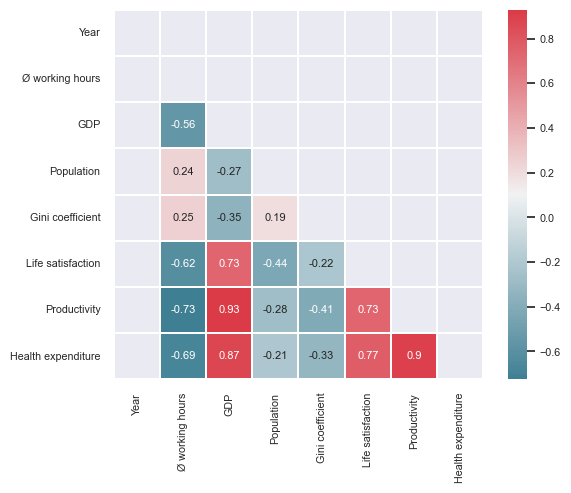

In [290]:
# Inspect correlation
# Calculate correlation using the default method ( "pearson")
corr = df.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=.7)
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 8}, linewidth=0.1);

As we work with observational data, we expected a correlation among the predictor variables. The matrix shows numerous high values, especially for productivity and GDP or Productivity and Health expenditure. Hence we have a collinearity problem which could cause a reduction on the precision of our estimated coefficients. It is questionable if we can identify independent variables that are significant as we cannot trust the p-value of our regression model.

### Variance inflation factor (VIF)
- The smallest possible value for VIF is 1, which indicates the complete absence of collinearity.
- VIF value that exceeds 5 indicates a problematic amount of collinearity and the parameter estimates will have large standard errors because of this.

In [292]:
# choose features and add constant
features = add_constant(df[['Ø working hours', 'GDP', 'Population','Gini coefficient','Life satisfaction','Health expenditure']])
# create empty DataFrame
vif = pd.DataFrame()
# calculate vif
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
# add feature names
vif["Feature"] = features.columns

vif.round(2)

,VIF Factor,Feature
0,295.25,const
1,2.03,Ø working hours
2,4.57,GDP
3,1.35,Population
4,1.19,Gini coefficient
5,3.25,Life satisfaction
6,6.28,Health expenditure


We have some problematic amount of collinearity in our data.
- Health expenditure
- GDP

## **Lasso regression model**

Lasso regression is based on the linear regression model, but additionally performs what is known as regularization, where additional information is introduced to prevent overfitting.
As a result, we can fit a model containing all possible predictors and use lasso to perform variable selection using a technique that regularizes the coefficient estimates (it shrinks the coefficient estimates to zero). In particular, the minimization objective includes not only the residual sum of squares (RSS) - as in the OLS regression setting - but also the sum of the absolute values of coefficients.

### Create labels and features

Since we will use the lasso algorithm from scikit learn, we need to encode our categorical features as numeric features (dummy variables):

In [293]:
dummies = pd.get_dummies(df[['Continent']])

We create our label y:

In [294]:
y_LR = df['Productivity']

We drop the column with the outcome variable (Productivity), and categorical columns for which we already created dummy variables:

In [295]:
X_numerical = df.drop(['Productivity', 'Continent', 'Country', 'Code', 'Year'], axis=1).astype('float64')

Make a list of all numerical features (we need them later):

In [296]:
# Make a list of all numerical features (we need them later):
list_numerical = X_numerical.columns

Create all features:

In [297]:
X_LR = pd.concat([X_numerical, dummies[['Continent_Americas', 'Continent_Oceania', 'Continent_Europe', 'Continent_Asia', 'Continent_Africa']]], axis=1)

### Split data

Split the data set into train and test set with the first 70% of the data for training and the remaining 30% for testing:

In [298]:
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_LR, y_LR, test_size=0.3, random_state=10)

### Standardization

To avoid data leaks, the standardization of numerical features should always be done after data splitting and only from training data. In addition, we obtain all necessary statistics for our features (mean and standard deviation) from training data and use them for test data as well. Note that we do not standardize our dummy variables (which only have values of 0 or 1).

In [299]:
scaler = StandardScaler().fit(X_train_LR[list_numerical]) 

X_train_LR[list_numerical] = scaler.transform(X_train_LR[list_numerical])
X_test_LR[list_numerical] = scaler.transform(X_test_LR[list_numerical])

In [300]:
X_train_LR.head()

,Ø working hours,GDP,Population,Gini coefficient,Life satisfaction,Health expenditure,Continent_Americas,Continent_Oceania,Continent_Europe,Continent_Asia,Continent_Africa
53,1.584451,-1.158539,-0.115808,-0.146033,-1.551031,-0.856020,0,0,0,0,1
10,1.427445,-1.095647,6.335670,0.712560,-1.416942,-1.044839,0,0,0,1,0
46,0.768288,-0.241857,-0.202113,-0.795642,-0.069422,-0.449489,0,0,1,0,0
44,0.334271,-1.202281,-0.235129,1.437013,-0.367298,-1.083565,1,0,0,0,0
35,1.716329,-0.516570,-0.233364,-0.146033,-1.068599,-0.912597,0,0,0,1,0


### Lasso regression

First, we apply lasso regression on the training set with an arbitrarily regularization parameter **alpha** of 1

In [301]:
reg_LR = Lasso(alpha=1)
reg_LR.fit(X_train_LR, y_train_LR)

Lasso(alpha=1)

### Model evaluation

We print the R-squared score for the training and test set.

In [302]:
print('R squared training set', round(reg_LR.score(X_train_LR, y_train_LR)*100, 2))
print('R squared test set', round(reg_LR.score(X_test_LR, y_test_LR)*100, 2))

R squared training set 93.49
R squared test set 89.52


MSE for the training and test set

In [303]:
# Training data
pred_train_LR = reg_LR.predict(X_train_LR)
mse_train_LR = mean_squared_error(y_train_LR, pred_train_LR)
print('MSE training set', round(mse_train_LR, 2))

# Test data
pred_LR = reg_LR.predict(X_test_LR)
mse_test_LR =mean_squared_error(y_test_LR, pred_LR)
print('MSE test set', round(mse_test_LR, 2))

MSE training set 32.97
MSE test set 68.77


### Role of alpha

To better understand the role of alpha, we plot the lasso coefficients as a function of alpha (max_iter are the maximum number of iterations) please find the visualization in Appendix.

Moving from left to right in our plot, we notice that the lasso models initially contain many predictors with high magnitudes of coefficient estimates. As the alpha increases, the coefficient estimates approach zero.

### Lasso with optimal alpha

To find the optimal value of alpha, we use scikit learns lasso linear model with iterative fitting along a regularization path (LassoCV). The best model is selected by cross-validation.

### K-fold cross validation

In [304]:
# Lasso with 5 fold cross-validation
model_LR = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model_LR.fit(X_train_LR, y_train_LR)

LassoCV(cv=5, max_iter=10000, random_state=0)

Show best value of penalization chosen by cross validation:

In [305]:
model_LR.alpha_

0.05302299651985887

### Best model

Use best value for our final model:

In [306]:
# Set best alpha
lasso_best = Lasso(alpha=model_LR.alpha_)
lasso_best.fit(X_train_LR, y_train_LR)

Lasso(alpha=0.05302299651985887)

Show model coefficients and names:

In [307]:
results_LB = pd.DataFrame({'': ['Ø-working hours','GDP','Population','Gini coefficient','Life satisfaction','Health expenditure','Continent_Americas','Continent_Oceania','Continent_Europe','Continent_Asia','Continent_Africa'],
                        'Lasso Regression Coefficients': [(lasso_best.coef_[0].round(5)),
                        (lasso_best.coef_[1].round(5)),
                        (lasso_best.coef_[2].round(5)),
                        (lasso_best.coef_[3].round(5)),
                        (lasso_best.coef_[4].round(5)),
                        (lasso_best.coef_[5].round(5)),
                        (lasso_best.coef_[6].round(5)),
                        (lasso_best.coef_[7].round(5)),
                        (lasso_best.coef_[8].round(5)),
                        (lasso_best.coef_[9].round(5)),
                        (lasso_best.coef_[10].round(5))]})

results_LB


,,Lasso Regression Coefficients
0,Ø-working hours,-5.17080
1,GDP,20.40429
2,Population,-0.01506
3,Gini coefficient,-0.06025
4,Life satisfaction,-2.09740
5,Health expenditure,-0.28723
6,Continent_Americas,0.00000
7,Continent_Oceania,-2.73003
8,Continent_Europe,0.00000
9,Continent_Asia,-1.46664


### Model evaluation

R² for lasso regression model:

In [308]:
print('R squared training set', round(lasso_best.score(X_train_LR, y_train_LR)*100, 2))
print('R squared test set', round(lasso_best.score(X_test_LR, y_test_LR)*100, 2))

R squared training set 96.08
R squared test set 83.27


MSE for lasso regression model:

In [309]:
mean_squared_error(y_test_LR, lasso_best.predict(X_test_LR))

109.71381501276998

## Results

Result of our **first research question**
- Result table of simple linear regression:

In [310]:
results_RQ1 = pd.DataFrame({'': ['Intercept','Coefficient'],
                        'Simple Linear Regression': [reg_H1.intercept_, reg_H1.coef_.round(5)]})

results_RQ1

,,Simple Linear Regression
0,Intercept,163.016654
1,Coefficient,[-0.06613]


In [311]:
results_RQ1_1 = pd.DataFrame({'': ['R²','Adjusted R²','MSE','RMSE','MAE'],
                        'Simple Linear Regression': [(r2_score(y_test_H1, y_pred_H1).round(5)),
                        ((1-(1-r2_score(y_test_H1, y_pred_H1))*((len(X_test_H1)-1)/(len(X_test_H1)-len(X_test_H1.columns)-1))).round(5)),
                        (mean_squared_error(y_test_H1, y_pred_H1).round(5)),
                        (mean_squared_error(y_test_H1, y_pred_H1, squared=False).round(5)),
                        (mean_absolute_error(y_test_H1, y_pred_H1).round(5))]})

results_RQ1_1

,,Simple Linear Regression
0,R²,0.51931
1,Adjusted R²,0.47926
2,MSE,195.77492
3,RMSE,13.99196
4,MAE,11.17991


As we mentioned during the analysis above, the p-value is statistically significant. It shows strong evidence against the null hypothesis as the probability is less than 5%. We can therefore reject our null hypothesis and accept the following hypothesis:
- There is a correlation between Ø-working hours and Productivity.

- However, from this result we can also see that there is strong multicollinearity or other numerical problems in this model. In the case of multicollinearity, this reduces the accuracy of the estimated coefficients, which weakens the statistical power of your regression model. Therefore we might not be able to trust the p-values to identify independent variables that are statistically significant.

- Also, we see a small R² of our model, which means that the quality of the model is low.

Result of our **second research question**
- Result table of multiple linear regression and lasso regression:

In [312]:
results_RQ2_1 = pd.DataFrame({'': ['R²','Adjusted R²','MSE','RMSE','MAE'],
                        'Multiple Linear Regression': [(r2_score(y_test, y_pred_test).round(5)),
                        ((1-(1-r2_score(y_test, y_pred_test))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))).round(5)),
                        (mean_squared_error(y_test, y_pred_test).round(5)),
                        (mean_squared_error(y_test, y_pred_test, squared=False).round(5)),
                        (mean_absolute_error(y_test, y_pred_test).round(5))], 
                        'Lasso Regression': [(r2_score(y_test_LR, lasso_best.predict(X_test_LR)).round(5)),
                        ((1-(1-r2_score(y_test_LR, lasso_best.predict(X_test_LR)))*((len(X_test_LR)-1)/(len(X_test_LR)-len(X_test_LR.columns)-1))).round(5)),
                        (mean_squared_error(y_test_LR, lasso_best.predict(X_test_LR)).round(5)),
                        (mean_squared_error(y_test_LR, lasso_best.predict(X_test_LR), squared=False).round(5)),
                        (mean_absolute_error(y_test_LR, lasso_best.predict(X_test_LR)).round(5))]})

results_RQ2_1

,,Multiple Linear Regression,Lasso Regression
0,R²,0.89788,0.83274
1,Adjusted R²,0.81035,0.60276
2,MSE,41.59040,109.71382
3,RMSE,6.44906,10.47444
4,MAE,4.16722,6.65880


By comparing the statistics of those models, it can be seen that the lasso regression model has a lower model quality than the multiple regression model.
- R² of the lasso regression model is smaller than that of the multiple regression model.
- Adjusted R² of the lasso regression model is also smaller then that of the multiple regression model.
- The mean squared error, root mean squared error and mean absolute error of lasso regression model are also higher than that of the multiple regression model.

Hence, this indicates that the multiple linear regression model is preferable to the lasso regression model.

## Discussion + Conclusion


In this analysis, we used various models to test the two hypotheses mentioned in the introduction. By using models such as simple regression analysis, multiple regression analysis, and Lasso regression, we could observe the problems regarding to number of explanatory variables as well as multicollinearity between those variables, which could cause a reduction on the precision of our estimated coefficients.
For future analyses, we should reduce the number of the predictors are choose alternative predictor variables in order to correctly evaluate our hypothesis.

Despite these problems, we were able to explain two things about our hypothese:
- Productivity decreases with increasing average annual working hours, but the negative relationship is not as strong as expected.
- While we can say that a country's Life satisfaction is strongly correlated with labor productivity growth, we cannot say that it is the most relevant factor. This is because, contrary to expectations, the Gini coefficient has a large correlation with Productivity.

*What happens in real world?*
Our models are just an example statistic that does not 100 % reflect the real world. The real world is more complicated than we think and there are different variables, so we have to keep in mind that there are unexpected variables that can affect our response variable. Therefore, we must be careful with this interpretation. Although there are real associations, these data are observational data and cannot accurately interpret the causal relationship between variables in real world.

### open topics
- We feel that the quantity of observations will not suffice (at least 500 Obsevations required) to train the model properly -> conclusion (Ji Soo) 
- Add the null hypothesises for your questions? (Ji Soo) - Null hypothesis for first research question was added *done*
- Reflect on how good models are performing and give possible solutions (Ji Soo)
- Be carefull when using productivity, explain why the GDP matters as a productivty indicator to be set in relation with hours. (Alex)

- Code Notiz als Markdown (Alex)
- Quellangabe (alex)
- Results in conclusion (Ji Soo) *done*

### look
Informative title and axis labels

Flipped coordinates to make names readable

Arranged bars based on count

Capitalized names

Optional: Added color - Use a coordinated color scheme throughout paper / presentation

Optional: Applied a theme - Use same theme throughout paper / presentation

# Sources
Research Question:
- OECD (2022), Labour productivity and utilisation (indicator). doi: 10.1787/02c02f63-en (Accessed on 11 December 2022) https://www.oecd-ilibrary.org/sites/3d9f648d-en/index.html?itemId=/content/component/3d9f648d-en
- Pencavel, J. (2016), Recovery from Work and the Productivity of Working Hours. Economica, 83: 545-563. https://doi.org/10.1111/ecca.12206
- Messenger, J. "Working time and the future of work." ILO future of work research paper series 6.8 (2018): 33-37. http://www.ilo.int/wcmsp5/groups/public/---dgreports/---cabinet/documents/publication/wcms_649907.pdf

Explorative data analysis:
- Shelke, Mayuri S., Prashant R. Deshmukh, and Vijaya K. Shandilya. "A review on imbalanced data handling using undersampling and oversampling technique." Int. J. Recent Trends Eng. Res 3.4 (2017): 444-449.


# Appendix

### Source description

The original source of this data is the website https://ourworldindata.org/ which does specific analysis based on data gathered from various books and sources. The website has made it possible to observe each important indicator through various data visualizations based on different countries and on time scales. All data required for the purpose of our research was obtained from four main analyzes of original sources, all data provided in these analyzes are data from various published books and scholarly sources.
- Four main analzyes of original website:
  - Working hours
  - Income Inequality
  - Life Expectancy
  - Happiness and Life Satisfaction
Since we collected the necessary data after selecting the research topic first, we searched for analysis data with indicators suitable for the research purpose.


At each of the links below, we collected various csv files for research purposes, and further integrated and organized the data for analysis through scripting in **MySQL**. 

 - Annual working hours per worker (https://ourworldindata.org/grapher/annual-working-hours-per-worker): The measure is labeled “Average annual hours worked by persons engaged” (PWT label) and “Average annual hours worked per worker” (TED label). It refers to actual hours worked and is calculated as total annual hours worked divided by persons employed. Annual hours are based on estimates of weekly working hours and weeks worked.
The original sources are National Accounts data when available; when unavailable, other databases (e.g., the Asian Productivity Organization’s Asian Productivity Database) and academic publications are used. 

  - Annual working hours vs. GDP per capita (https://ourworldindata.org/grapher/annual-working-hours-vs-gdp-per-capita-pwt?time=2019..latest): GDP per capita was extracted from Penn World Table (PWT), a standard source on real GDP across countries. Making use of prices collected across countries in benchmark years by the International Comparisons Program, and using these prices to construct
purchasing-power-parity exchange rates, PWT converts GDP at national prices to a common currency – U.S. dollars – making them comparable across countries.

  - Productivity (https://ourworldindata.org/grapher/labor-productivity-per-hour-pennworldtable?country=AUS~BEL~BRA~KHM~CHL~CHN~DEU~IND~ZAF~KOR~TWN~GBR~USA~CHE): Productivity is measured as GDP per hour of work. Again PWT was used as a source.

  - Life expectancy vs. healthcare expenditure (https://ourworldindata.org/grapher/life-expectancy-vs-healthcare-expenditure): The health expenditure estimates have been prepared by the World Health Organization (WHO) under the framework of the System of Health Accounts 2011 (SHA 2011). The Health SHA 2011 tracks all health spending in a given country over a defined period of time regardless of the entity or institution that financed and managed that spending. It generates consistent and comprehensive data on health spending in a country, which in turn can contribute to evidence-based policy-making. 

  - Income inequality: Gini coefficient (https://ourworldindata.org/grapher/economic-inequality-gini-index): This data explorer is collated and adapted from the World Bank’s Poverty and Inequality Platform (PIP). The World Bank’s PIP data is a large collection of household surveys where steps have been taken by the World Bank to harmonize definitions and methods across countries and over time.
      
  - Self-reported life satisfaction (https://ourworldindata.org/grapher/happiness-cantril-ladder): The data is puplished by the World Happiness Report. Life evaluation was measured by the individual answers to the Cantril ladder question: “Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?” The value shown in a given year is the average of that year and the previous and following year. For example, the value given for 2020 is an average of the values for 2019-2021.



### Data dictionary

In [313]:
data_dictionary = {'Name': list(df.columns.values),
            'Description': ['Continent name','Country name','Country codes by alpha-3','Year: Only 2017 data was considered in this analysis to satisfy the independence condition','Working hours are the annual average per worker.','The GDP per capita by country in 2017 is listed.','The number of population by country in 2017 is listed.','The 2017 Gini coefficient for each country is listed, so the level of income inequality can be determined.','The level of life satisfaction for each country has been measured by survey: “Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”','Productivity is measured as gross domestic product (GDP) per hour of work. This data is adjusted for inflation and for differences in the cost of living between countries.','Healthcare expenditure per capita is measured in current international-$, which adjusts for price differences between countries.'],
            'Role': ['ID','ID','ID','ID','Predictor','Predictor','Predictor','Predictor','Predictor','Response','Predictor'],
            'Type': ['nominal','nominal','nominal','numeric','numeric','numeric','numeric','numeric','numeric','numeric','numeric'],
            'Format': list(df.dtypes)}

df_dictionary = pd.DataFrame(data_dictionary)
df_dictionary

,Name,Description,Role,Type,Format
0,Continent,Continent name,ID,nominal,category
1,Country,Country name,ID,nominal,object
2,Code,Country codes by alpha-3,ID,nominal,object
3,Year,Year: Only 2017 data was considered in this an...,ID,numeric,int64
4,Ø working hours,Working hours are the annual average per worker.,Predictor,numeric,float64
5,GDP,The GDP per capita by country in 2017 is listed.,Predictor,numeric,float64
6,Population,The number of population by country in 2017 is...,Predictor,numeric,int64
7,Gini coefficient,The 2017 Gini coefficient for each country is ...,Predictor,numeric,float64
8,Life satisfaction,The level of life satisfaction for each countr...,Predictor,numeric,float64
9,Productivity,Productivity is measured as gross domestic pro...,Response,numeric,float64


Introduction
- Motivation
- Research Question / Hypothesis
- Data description
- EDA
Methodology / Results
- SLR
- MLR
- Lasso
Conclusion

* what comes first: data correction or data explaration?

### Chart 1: Gini coefficient - distribution plot and boxplot

In [314]:
# By using distribution plot we can decide which technique we will use for dealing with missing values.
# Variable = Gini coefficient

# Histogram
hist = alt.Chart(df).mark_bar().encode(
    x=alt.X("Gini coefficient", 
            bin=alt.BinParams(maxbins=20), 
            scale=alt.Scale(zero=True)),
    y='count()',
)

# Boxplot 
box = alt.Chart(df).mark_boxplot().encode(
    x='Gini coefficient',
)

alt.vconcat(hist, box)

c:\Users\ji_so\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

### Chart 2: Life satisfaction - distribution plot and boxplot

In [315]:
# By using distribution plot we can decide which technique we will use for dealing with missing values.
# Variable = Life satisfaction

hist1 = alt.Chart(df).mark_bar().encode(
    x=alt.X("Life satisfaction", 
            bin=alt.BinParams(maxbins=20), 
            scale=alt.Scale(zero=True)),
    y='count()',
)

box1 = alt.Chart(df).mark_boxplot().encode(
    x='Life satisfaction',
)

alt.vconcat(hist1, box1)

alt.VConcatChart(...)

### Chart 3: Productivity - distribution plot and boxplot

In [316]:
# By using distribution plot we can decide which technique we will use for dealing with missing values.
# Variable = Productivity

hist2 = alt.Chart(df).mark_bar().encode(
    x=alt.X("Productivity", 
            bin=alt.BinParams(maxbins=20), 
            scale=alt.Scale(zero=True)),
    y='count()',
)

box2 = alt.Chart(df).mark_boxplot().encode(
    x='Productivity',
)

alt.vconcat(hist2, box2)

alt.VConcatChart(...)

### Chart 4: Current health expenditure per capita - distribution plot and boxplot

In [317]:
# By using distribution plot we can decide which technique we will use for dealing with missing values.
# Variable = Current health expenditure per capita

hist3 = alt.Chart(df).mark_bar().encode(
    x=alt.X("Health expenditure", 
            bin=alt.BinParams(maxbins=20), 
            scale=alt.Scale(zero=True)),
    y='count()',
)

box3 = alt.Chart(df).mark_boxplot().encode(
    x='Health expenditure',
)

alt.vconcat(hist3, box3)


alt.VConcatChart(...)

### Chart 5: Role of alpha

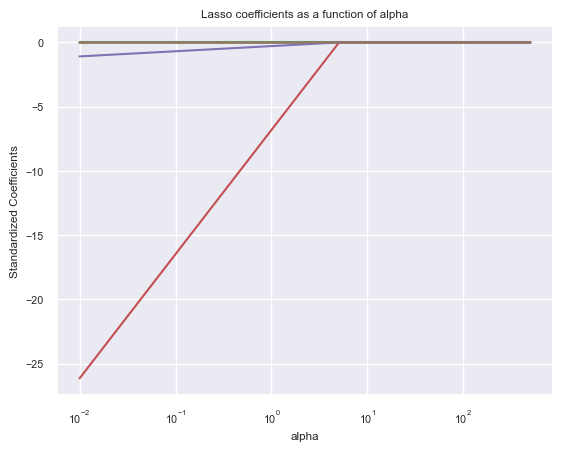

In [318]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');